In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import UNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc

## Parameters

In [3]:
img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR
exp = 1

img_type = 'OPT'
cond = 'no_cloudy'

## Load file

In [4]:
image_array = np.load(os.path.join(img_path, f'fus_stack_{cond}.npy'))

if img_type == 'OPT':
    image_array = image_array[:, :, :n_opt_layer]
    
if img_type == 'SAR':
    image_array = image_array[:, :, n_opt_layer:]
    
print('Image stack:', image_array.shape)

final_mask1 = np.load(os.path.join(img_path, 'final_mask1.npy'))
print('Labels stack:', final_mask1.shape)
h_, w_, channels = image_array.shape

Image stack: (17730, 9203, 26)
Labels stack: (17730, 9203)


## Create tiles mask

mask:  (17730, 9203)
image stack:  (17730, 9203, 26)
ref : (17730, 9203)


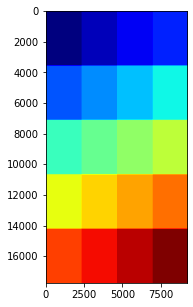

In [5]:
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.figure(figsize=(10,5))
plt.imshow(mask_tiles, cmap='jet')

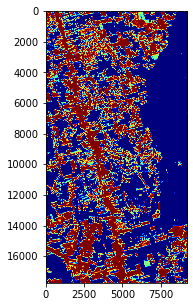

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

## Define tiles for training, validation and tests.

In [7]:
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

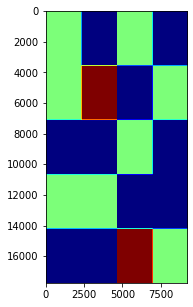

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(mask_tr_val, cmap='jet')

## Create index image to extract patches without overcharge the system.

In [9]:
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)

patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size) #índice do pixel de cada patch
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size) #1 se pixel for de treinamento 2 se for val
del im_idx

## Select training, validation and test patches, keeping a minumum of 2% of deforestation pixels, to minimize the imbalance.

In [10]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2)) #extrai apenas idx dos patches com todos os valores == 1 (train)
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2)) #extrai apenas idx dos patches com todos os valores == 2 (val)
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   41812 Number of validation patches 10260


In [11]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(2991, 128, 128) (836, 128, 128)


In [12]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

Y_train = np.zeros_like(X_train)
Y_valid = np.zeros_like(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), Y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), Y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3


In [13]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, _ = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

In [14]:
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)

In [15]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(img_path, 'models')
path_maps = os.path.join(img_path, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [16]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'unet'
model = UNET(nb_filters, number_class)

In [17]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-3 , beta_1=0.9)
#loss = weighted_categorical_crossentropy(weights)
loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [18]:
metrics_all = []
times=10
for tm in range(0,times):
    print('time: ', tm)
    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    loss = WBCE(weights = weights)
    model = UNET(nb_filters, number_class)
    model.build((None,)+input_shape)
    model.summary()
    
    # train the model
    start_training = time.time()
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(os.path.join(path_models, f'{method}_{tm}.h5'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    callbacks_list = [earlystop, checkpoint]
    history = model.fit(train_gen_crops,
                              steps_per_epoch=(len(X_train)//train_gen.batch_size)+1,
                              validation_data=valid_gen_crops,
                              validation_steps=(len(X_valid)//valid_gen.batch_size)+1,
                              epochs=100,
                              callbacks=callbacks_list)
    
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history
del image_array, Y_train, Y_valid, X_train, X_valid
gc.collect()

time:  0
Model: "unet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unet_encoder (UNET_Encoder)  multiple                  542624    
_________________________________________________________________
unet_decoder (UNET_Decoder)  multiple                  332000    
_________________________________________________________________
classifier (Classifier)      multiple                  195       
Total params: 874,819
Trainable params: 874,819
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 17s 113ms/step - loss: 0.1170 - accuracy: 0.7391 - val_loss: 0.0723 - val_accuracy: 0.8293

Epoch 00001: val_loss improved from inf to 0.07234, saving model to imgs\models\unet_0.h5
Epoch 2/100
94/94 [==============================] - 9s 97ms/step - loss: 0.0722 - accuracy: 0.8298 - val_loss: 0.0756 - val_accuracy: 0.829

94/94 [==============================] - 9s 95ms/step - loss: 0.1061 - accuracy: 0.7523 - val_loss: 0.0688 - val_accuracy: 0.8391

Epoch 00001: val_loss improved from inf to 0.06884, saving model to imgs\models\unet_2.h5
Epoch 2/100
94/94 [==============================] - 9s 94ms/step - loss: 0.0721 - accuracy: 0.8315 - val_loss: 0.0748 - val_accuracy: 0.8327

Epoch 00002: val_loss did not improve from 0.06884
Epoch 3/100
94/94 [==============================] - 9s 94ms/step - loss: 0.0660 - accuracy: 0.8379 - val_loss: 0.0719 - val_accuracy: 0.8324

Epoch 00003: val_loss did not improve from 0.06884
Epoch 4/100
94/94 [==============================] - 9s 94ms/step - loss: 0.0618 - accuracy: 0.8426 - val_loss: 0.0783 - val_accuracy: 0.8298

Epoch 00004: val_loss did not improve from 0.06884
Epoch 5/100
94/94 [==============================] - 9s 94ms/step - loss: 0.0586 - accuracy: 0.8459 - val_loss: 0.0935 - val_accuracy: 0.8240

Epoch 00005: val_loss did not improve from 0.06884
Epo


Epoch 00008: val_loss did not improve from 0.06515
Epoch 9/100
94/94 [==============================] - 9s 97ms/step - loss: 0.0543 - accuracy: 0.8535 - val_loss: 0.0847 - val_accuracy: 0.8242

Epoch 00009: val_loss did not improve from 0.06515
Epoch 10/100
94/94 [==============================] - 9s 97ms/step - loss: 0.0552 - accuracy: 0.8539 - val_loss: 0.0770 - val_accuracy: 0.8264

Epoch 00010: val_loss did not improve from 0.06515
Epoch 11/100
94/94 [==============================] - 9s 97ms/step - loss: 0.0521 - accuracy: 0.8564 - val_loss: 0.0680 - val_accuracy: 0.8385

Epoch 00011: val_loss did not improve from 0.06515
Epoch 12/100
94/94 [==============================] - 9s 98ms/step - loss: 0.0495 - accuracy: 0.8625 - val_loss: 0.0671 - val_accuracy: 0.8381

Epoch 00012: val_loss did not improve from 0.06515
Epoch 13/100
94/94 [==============================] - 9s 98ms/step - loss: 0.0503 - accuracy: 0.8627 - val_loss: 0.0749 - val_accuracy: 0.8289

Epoch 00013: val_loss did

94/94 [==============================] - 10s 104ms/step - loss: 0.0460 - accuracy: 0.8687 - val_loss: 0.0833 - val_accuracy: 0.8276

Epoch 00014: val_loss did not improve from 0.06249
Epoch 15/100
94/94 [==============================] - 10s 105ms/step - loss: 0.0437 - accuracy: 0.8719 - val_loss: 0.1028 - val_accuracy: 0.8188

Epoch 00015: val_loss did not improve from 0.06249
Epoch 00015: early stopping
time:  7
Model: "unet_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unet_encoder (UNET_Encoder)  multiple                  542624    
_________________________________________________________________
unet_decoder (UNET_Decoder)  multiple                  332000    
_________________________________________________________________
classifier (Classifier)      multiple                  195       
Total params: 874,819
Trainable params: 874,819
Non-trainable params: 0
________________________________

94/94 [==============================] - 11s 112ms/step - loss: 0.1080 - accuracy: 0.7294 - val_loss: 0.0735 - val_accuracy: 0.8356: 0.1097 - ac

Epoch 00001: val_loss improved from inf to 0.07351, saving model to imgs\models\unet_9.h5
Epoch 2/100
94/94 [==============================] - 10s 110ms/step - loss: 0.0711 - accuracy: 0.8324 - val_loss: 0.0737 - val_accuracy: 0.8278

Epoch 00002: val_loss did not improve from 0.07351
Epoch 3/100
94/94 [==============================] - 10s 109ms/step - loss: 0.0647 - accuracy: 0.8426 - val_loss: 0.0722 - val_accuracy: 0.8258

Epoch 00003: val_loss improved from 0.07351 to 0.07224, saving model to imgs\models\unet_9.h5
Epoch 4/100
94/94 [==============================] - 10s 112ms/step - loss: 0.0650 - accuracy: 0.8379 - val_loss: 0.0905 - val_accuracy: 0.8158

Epoch 00004: val_loss did not improve from 0.07224
Epoch 5/100
94/94 [==============================] - 10s 110ms/step - loss: 0.0614 - accuracy: 0.8439 - val_loss: 0.0709 - val_accura

10016

In [19]:
test_cond = 'no_cloudy'
image_array = np.load(os.path.join(img_path, f'fus_stack_{test_cond}.npy'))
if img_type == 'OPT':
    image_array = image_array[:, :, :n_opt_layer]
    
if img_type == 'SAR':
    image_array = image_array[:, :, n_opt_layer:]
    
print('Image stack:', image_array.shape)

Image stack: (17730, 9203, 26)


In [20]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 20#5
n_cols = 16#4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

#if method == 'unet':
#   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

new_model = UNET(nb_filters, number_class)
new_model.build((None,)+input_shape)
adam = Adam(lr = 1e-3 , beta_1=0.9)
loss = WBCE(weights = weights)
#loss = weighted_categorical_crossentropy(weights)
new_model.compile(optimizer=adam, loss=loss, metrics=['accuracy'], run_eagerly=True)

for tm in range(0,times):
    print('time: ', tm)
    #model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    #for l in range(1, len(model.layers)):
    #    new_model.layers[l].set_weights(model.layers[l].get_weights())
    new_model.load_weights(os.path.join(path_models, f'{method}_{tm}.h5'))
    
    start_test = time.time()
    patch_list = []

    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            pred = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_list.append(pred[:,:,:,1])

            del pred
    end_test =  time.time() - start_test

    patches_pred = np.asarray(patch_list).astype(np.float32)
    
    del patch_list

    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    
    del patches_pred
    np.save(os.path.join(path_maps, f'prob_{tm}.npy'),prob_recontructed) 

    time_ts.append(end_test)
    del prob_recontructed
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(os.path.join(path_exp, 'metrics_ts.npy'), time_ts_array)
del image_array
gc.collect()

-30.0 -13.0
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


19632

In [21]:
# Compute mean of the tm predictions maps
prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(os.path.join(path_maps, f'prob_{tm}.npy')).astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)

np.save(os.path.join(path_maps, 'prob_mean.npy'), mean_prob)

0
1
2
3
4
5
6
7
8
9


(-0.5, 9202.5, 17729.5, -0.5)

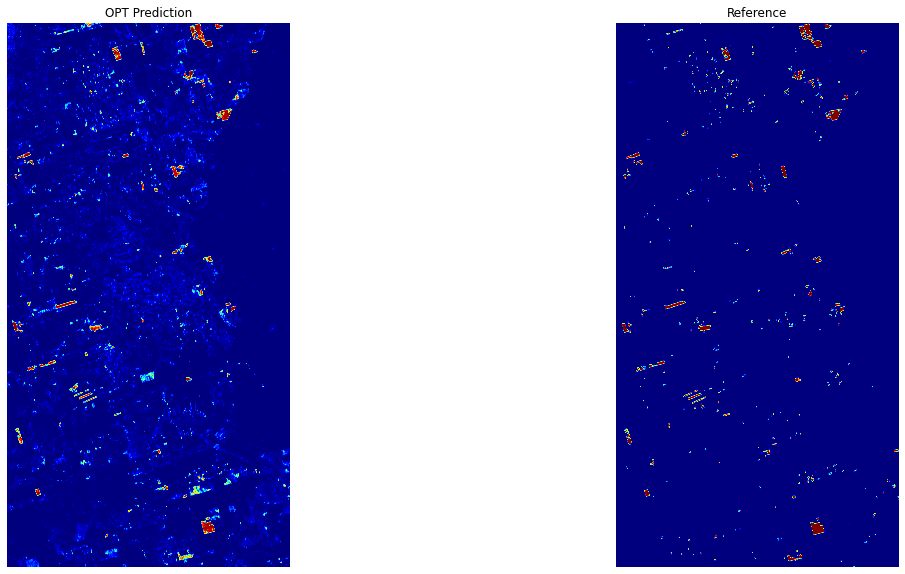

In [22]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
plt.title(f'{img_type} Prediction')
ax1.imshow(mean_prob, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(122)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [ ]:
# Computing metrics
t0 = time.time()
mean_prob = mean_prob[:final_mask1.shape[0], :final_mask1.shape[1]]


ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)

metrics = metrics_AP(ProbList, mean_prob, final_mask1, mask_amazon_ts, 625, 1)
   
np.save(os.path.join(path_exp, 'acc_metrics.npy'),metrics)

print(f'elapsed time: {(time.time()-t0)/60} mins')

In [ ]:
# Complete NaN values
metrics_copy = np.array(metrics)
metrics_copy = complete_nan_values(metrics_copy)


In [ ]:
# Comput Mean Average Precision (mAP) score 
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]
AA = metrics_copy[:,2]
   
DeltaR = Recall[1:]-Recall[:-1]
AP = np.sum(Precision[:-1]*DeltaR)
print(f'{img_type} mAP', AP)


# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy[:,0],metrics_copy[:,1], 'r-', label = f'{img_type} (AP: {AP:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()